<a href="https://colab.research.google.com/github/Alena-Mishchenko/homework_ds_11/blob/main/%D0%9A%D0%BE%D0%BF%D1%96%D1%8F_%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BD%D0%B8%D0%BA%D0%B0_%22GoIT_HW_8_new_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [17]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 2500 # максимальне число епох
batch_size = 512 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [18]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [19]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(num_features, n_hidden_1)

    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.layer_3 = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax

    x = self.layer_1(x, activation=0)
    # x = tf.nn.sigmoid(x)

    x = self.layer_2(x, activation=0)
    # x = tf.nn.sigmoid(x)

    return self.layer_3(x, activation=1)

In [20]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_true = tf.cast(y_true, tf.int64)
    predicted_classes = tf.argmax(y_pred, axis=1)
    correct_prediction = tf.equal(predicted_classes, y_true)

    accurasy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accurasy

In [21]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів

    params = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, params)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, params))

In [22]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
     train(neural_net, batch_x, batch_y)
     if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        accuracy_value = accuracy(pred, batch_y)

        loss_history.append(loss)
        accuracy_history.append(accuracy_value)

        print(f"Step: {step}, Loss: {loss:.4f}, Accuracy: {accuracy_value:.4f}")



Step: 100, Loss: 498.4556, Accuracy: 0.7598
Step: 200, Loss: 355.2430, Accuracy: 0.8164
Step: 300, Loss: 252.5078, Accuracy: 0.8594
Step: 400, Loss: 271.5377, Accuracy: 0.8496
Step: 500, Loss: 184.7455, Accuracy: 0.8984
Step: 600, Loss: 232.7879, Accuracy: 0.8770
Step: 700, Loss: 137.4780, Accuracy: 0.9238
Step: 800, Loss: 202.9387, Accuracy: 0.8809
Step: 900, Loss: 194.6692, Accuracy: 0.8945
Step: 1000, Loss: 155.7905, Accuracy: 0.9121
Step: 1100, Loss: 185.2287, Accuracy: 0.8965
Step: 1200, Loss: 165.5961, Accuracy: 0.9102
Step: 1300, Loss: 145.5887, Accuracy: 0.9199
Step: 1400, Loss: 152.4044, Accuracy: 0.9121
Step: 1500, Loss: 143.1062, Accuracy: 0.9375
Step: 1600, Loss: 132.7970, Accuracy: 0.9258
Step: 1700, Loss: 107.1917, Accuracy: 0.9414
Step: 1800, Loss: 92.6572, Accuracy: 0.9336
Step: 1900, Loss: 113.2217, Accuracy: 0.9316
Step: 2000, Loss: 82.4676, Accuracy: 0.9512
Step: 2100, Loss: 92.8974, Accuracy: 0.9590
Step: 2200, Loss: 120.7545, Accuracy: 0.9316
Step: 2300, Loss: 114.

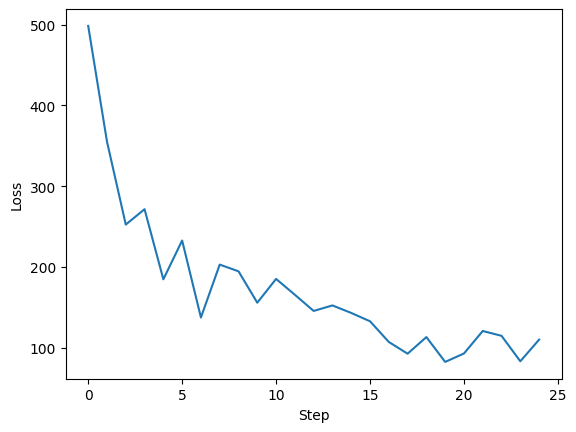

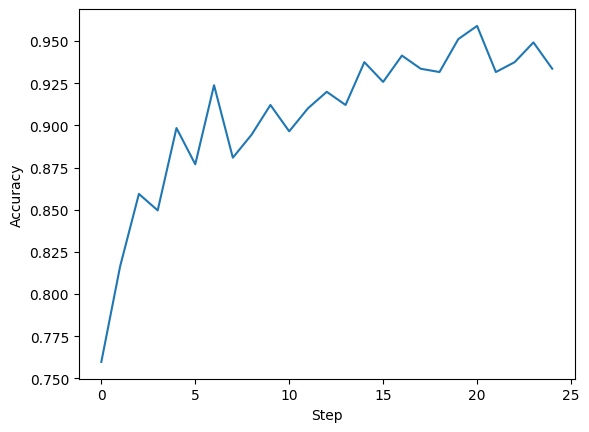

In [23]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history, label="Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history, label="Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.show()


In [24]:
# Обчисліть точність навченої нейромережі
average_training_accuracy = tf.reduce_mean(accuracy_history)
print(f"Середня точність на тренувальних даних: {average_training_accuracy:.4f}")

# Тестування моделі на тестових даних

total_accuracy = 0
num_batches = 0

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size)

# Прохід по тестовому датасету
for batch_x, batch_y in test_data:
    predictions = neural_net(batch_x)
    accuracy_value = accuracy(predictions, batch_y)

    total_accuracy += accuracy_value
    num_batches += 1

# Обчислення середньої точності на тестових даних
average_test_accuracy = total_accuracy / num_batches
print(f"Середня точність на тестових даних: {average_test_accuracy:.4f}")



Середня точність на тренувальних даних: 0.9057
Середня точність на тестових даних: 0.9170


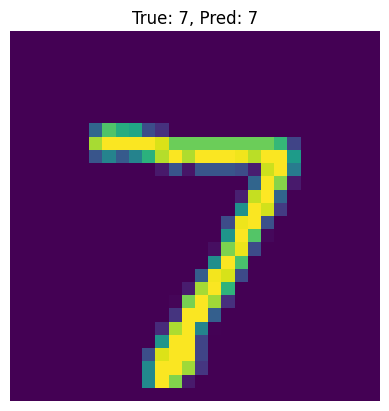

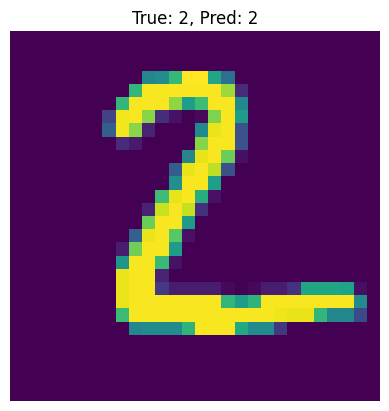

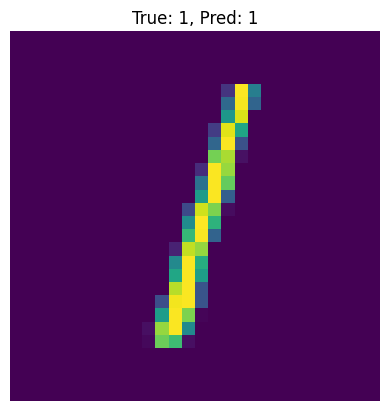

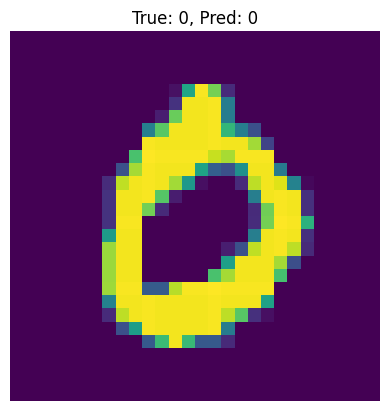

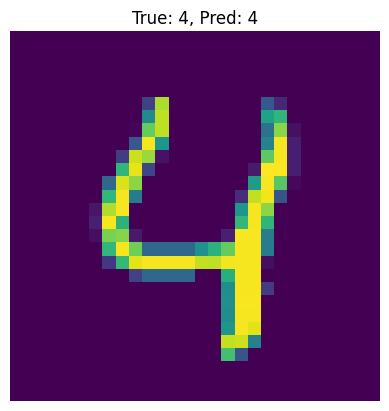

Кількість помилок з 5 зображень: 0
Точність на цих 5 зображеннях: 100.00%


In [25]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
num_test_images = 5
test_images = x_test[:num_test_images]
true_labels = y_test[:num_test_images]
predictions = neural_net(test_images)
predicted_labels = tf.argmax(predictions, axis=1)

for img, true_label, pred_label in zip(test_images, true_labels, predicted_labels):
    plt.imshow(img.reshape(28, 28))
    plt.title(f"True: {true_label}, Pred: {pred_label.numpy()}")
    plt.axis('off')
    plt.show()
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

errors = sum(int(true_label != pred_label.numpy()) for true_label, pred_label in zip(true_labels, predicted_labels))
print(f"Кількість помилок з 5 зображень: {errors}")
print(f"Точність на цих 5 зображеннях: {(5 - errors) / 5 * 100:.2f}%")


